In [1]:
from src import myModel, DataGenerator, split_trn_vld_tst
import matplotlib.pyplot as plt
import numpy as np

C:\Users\yuch\Downloads\anaconda3\envs\nz_convnet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### load X-Y samples from block1, and split into train and test sets

In [2]:
X_trn, Y_trn, X_vld, Y_vld, X_tst, Y_tst = split_trn_vld_tst('./data/', vld_rate=0.2, tst_rate=0.1)

#### visualize images and labels

Text(0.5,1,'lithological mappinp')

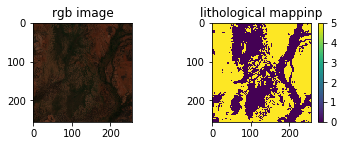

In [3]:
idx = 150
img = np.load(X_trn[idx])
lbl = np.load(Y_trn[idx])

img_rgb = np.transpose(img, [1,2,0])[:,:,::-1][:,:,-3:]
plt.subplot(221)
plt.imshow(img_rgb)
plt.title('rgb image')
plt.subplot(222)
plt.imshow(np.argmax(lbl, axis=0))
plt.colorbar()
plt.title('lithological mappinp')

#### start to build and train Conv2D

In [4]:
conv = myModel()

# build Conv2D
conv.build_Conv2D(num_bands=23, n_ch_list=[64,64])

# now the tensorboard event file is saved in ./logs
# the training process, graph and statistics can be
# visualize by tensorboard

# compile with loss and optimizer
conv.compile_model(verbose=False)

# build callback for the details of train process
conv.build_callbackList(use_tfboard=True)

building Conv2D ...
[64, 64]
[64]
compiling model ...


In [5]:
trn_data = DataGenerator(X_trn, Y_trn, batch_size=10)
vld_data = DataGenerator(X_vld, Y_vld, batch_size=10)

#### check data generator

In [6]:
x, y = trn_data.getitem(1)

Text(0.5,1,'label')

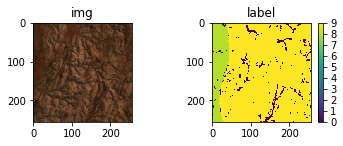

In [7]:
idx = 4
plt.subplot(221)
plt.imshow(2*np.transpose(x[idx,:,:,:], [1,2,0])[:,:,::-1][:,:,-3:])
plt.title('img')
plt.subplot(222)
plt.imshow(np.argmax(y[idx,:,:,:], axis=0))
plt.colorbar()
plt.title('label')

In [ ]:
conv.fit_model_generator(trn_data, vld_data, num_epochs=20)

Epoch 1/20
79/79 [==============================] - 2171s 27s/step - loss: 137.8557 - acc: 0.0256 - val_loss: 135.3546 - val_acc: 0.0105

Epoch 00001: val_acc improved from -inf to 0.01053, saving model to ./Conv2D/weights-01-0.01.hdf5
Epoch 2/20
79/79 [==============================] - 2239s 28s/step - loss: 134.7861 - acc: 0.0152 - val_loss: 133.6873 - val_acc: 0.0518

Epoch 00002: val_acc improved from 0.01053 to 0.05179, saving model to ./Conv2D/weights-02-0.05.hdf5
Epoch 3/20
79/79 [==============================] - 2159s 27s/step - loss: 134.2238 - acc: 0.0524 - val_loss: 133.5994 - val_acc: 0.0438

Epoch 00003: val_acc did not improve
Epoch 4/20
79/79 [==============================] - 2182s 28s/step - loss: 133.9586 - acc: 0.0757 - val_loss: 134.1631 - val_acc: 0.1032

Epoch 00004: val_acc improved from 0.05179 to 0.10319, saving model to ./Conv2D/weights-04-0.10.hdf5
Epoch 5/20
79/79 [==============================] - 2258s 29s/step - loss: 133.8867 - acc: 0.0973 - val_loss: 1

#### predict on test data

In [22]:
# conv.save_weights('./Conv2D/weights-11-.hdf5')
conv.save_weights(suffix='sent_geo')

In [10]:
X_tst, Y_tst = data.get_XY(min_list, max_list, start=220, num=40, as_arr=True, random=False)
print('have {0} image tiles in totle'.format(len(data.X)))

loading 220 - 259 image tiles
have 4296 image tiles in totle


In [11]:
Y_preds = conv.predict(X_tst=X_tst)

40/40 [==============================] - 33s 820ms/step


#### visualize predicted Y

Text(0.5,1,'prediction')

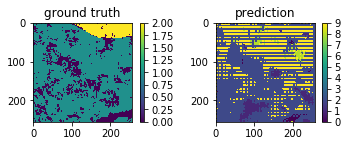

In [17]:
idx = 25
_pred = np.argmax(Y_preds[idx,:,:,:], axis=2)
_tst = np.argmax(Y_tst[idx,:,:,:], axis=2)
plt.subplot(221)
plt.imshow(_tst)
plt.colorbar()
plt.title('ground truth')
plt.subplot(222)
plt.imshow(_pred)
plt.colorbar()
plt.title('prediction')

#### calculate the accuracy

In [16]:
acc_list = []
for i in range(Y_tst.shape[0]):
    tmp_pred = np.argmax(Y_preds[i,:,:,:], axis=2)
    tmp_tst = np.argmax(Y_tst[i,:,:,:], axis=2)
    acc_list.append(np.where(tmp_pred == tmp_tst)[0].shape[0]/(256*256))
print('mean accuracy on test data is {0}, std is {1}'.format(np.mean(acc_list), np.std(acc_list)))
print('max is {0}, min is {1}'.format(max(acc_list), min(acc_list)))

mean accuracy on test data is 0.26898841857910155, std is 0.19582372201293222
max is 0.6697235107421875, min is 0.001922607421875


In [28]:
X_trn[19,:,:,0]

array([[4.2800002e-02, 4.1000001e-02, 4.2300001e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       [4.2199999e-02, 3.8100000e-02, 4.5899998e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       [4.4500001e-02, 3.7400000e-02, 3.9999999e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       ...,
       [4.4199999e-02, 4.6700001e-02, 4.0899999e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       [3.9400000e-02, 4.6000000e-02, 4.0899999e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       [3.6800001e-02, 4.2599998e-02, 4.6700001e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34]], dtype=float32)

In [41]:
tmp = data.img_to_array(data.X[92], min_list=min_list, max_list=max_list)

In [44]:
np.where(tmp>1)

(array([  0,   0,   0, ..., 255, 255, 255], dtype=int64),
 array([ 97,  97,  97, ..., 255, 255, 255], dtype=int64),
 array([ 0,  1,  2, ..., 20, 21, 22], dtype=int64))

In [45]:
tmp[0,97,0]

3.4028236e+34

In [46]:
from osgeo import gdal

In [59]:
file = gdal.Open(data.X[92])

In [66]:
aa = file.GetRasterBand(23)

In [52]:
path = './data/block1/sentinel_images/images/000000109.tif'

In [73]:
tmp[tmp>0.1] = 0